In [16]:
import torch
import os
from MResNet import *
'''
Code For 
Yiping Lu, Aoxiao Zhong, Quanzheng Li, Bin Dong. "Beyond Finite Layer Neural Network:Bridging Deep Architects and Numerical Differential Equations" 
Thirty-fifth International Conference on Machine Learning (ICML), 2018

@2prime @Aoxiao Zhong

Acknowledgement:
@pppppass(Zhihan Li)
'''
%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
net=MResNet20()
model_name = "Resnet20"

In [7]:
from torch.autograd import Variable
inp=Variable(torch.FloatTensor(128,3,32,32).uniform_(0,1))

In [8]:
net.cuda()
%timeit net(inp.cuda())

4.4 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
import datetime

def write_file_and_close(filename, *arg, flag = "a"):
    with open(filename, flag) as output_file:
        output_file.write(str(datetime.datetime.now()))
        output_file.write(":\n")
        output_file.write(*arg)
        output_file.write("\n")
        print(*arg)

def check_control(filename):
    with open(filename, "r") as filename:
        try:
            u = int(filename.read().strip())
            return bool(u)
        except:
            write_file_and_close("Error occured checking control!!!")
            return False

def generate_filename(modelname,code = None):
    # if code = None, generate tim as the code
    if code == None:
        return 'result/'+modelname + '-' + datetime.datetime.now().strftime("%Y%m%d%H%M%S%f") + ".mdlpkl"
    return 'result/'+modelname + '-test' + str(code) + ".mdlpkl"


In [18]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import re
import numpy

import os

import sys, time


def train_epoch(net,optimizer,trainloader,testloader,it,control_dict,global_output_filename = "out.txt"):
    """
    SGD Trainer For Cross Entropy Loss
    :param net:
    :param sgd_para: sgd parameters(should be a dictionary)
    :param trainloader:
    :param testloader:
    :param it: iteration time
    :param lr_adjust: learning rate adjust
    :param global_output_filename:
    :param global_control_filename:
    :return:None
    """
    # to do L2loss or other losses

    def lr_control(control_dict, it):
        for i in control_dict:
            if it <= i:
                return control_dict[i]

    criterion = nn.CrossEntropyLoss()

    global_cuda_available = torch.cuda.is_available()
    if global_cuda_available:
        net = net.cuda()



    def train(data, info):
        net.train()#turn to train mode
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        if global_cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        info[0] = loss.data[0]
        info[1] = labels.size()[0]

    def test(info):
        net.eval()# trun to eval mode
        correct_sum = 0
        total_loss_sum = 0.
        total_ctr = 0
        for data in testloader:
            inputs, labels = data
            inputs, labels = Variable(inputs,volatile=True), Variable(labels,volatile=True)
            if global_cuda_available:
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_ctr += labels.size()[0]
            correct_sum += (predicted == labels.data).sum()
            loss = criterion(outputs, labels)
            total_loss_sum += loss.data[0]
        info[0] = correct_sum
        info[1] = total_ctr
        info[2] = total_loss_sum

    running_loss_sum = 0.
    total_loss_sum = 0.
    ctr_sum = 0
    total_ctr = 0
    for g in optimizer.param_groups:
        g["lr"] = lr_control(control_dict,it)
    for i, data in enumerate(trainloader):
        info = [0., 0]
        train(data, info)
        running_loss_sum += info[0]
        total_loss_sum += info[0]
        ctr_sum += 1
        total_ctr += info[1]
        if (i + 1) % 20 == 0:
            write_file_and_close(global_output_filename,
                                 "epoch: {:d}, "
                                 "train set index: {:d}, "
                                 "average loss: {:.10f}"
                                 .format(it, i, running_loss_sum / ctr_sum)
                                 )
            running_loss_sum = 0.0
            ctr_sum = 0
        # it = it + 1
    write_file_and_close(global_output_filename,
                         "Epoch {:d} finished, average loss: {:.10f}"
                         .format(it, total_loss_sum / total_ctr)
                         )
    if True:
        write_file_and_close(global_output_filename, "Starting testing")
        info = [0., 0., 0.]
        test(info)
        write_file_and_close(global_output_filename,
                             "Correct: {:d}, total: {:d}, "
                             "accuracy: {:.10f}, average loss: {:.10f}"
                             .format(info[0], info[1], info[0] / info[1], info[2] / info[1])
                             )
        return info[0]


class NN_SGDTrainer(object):
    def __init__(self,net,sgd_para,trainloader,testloader,lr_adjust,global_output_filename = "out.txt"):
        self.net = net
        self.sgd_para = sgd_para
        self.optimizer = optim.SGD(net.parameters(), **sgd_para)
        self.trainloader = trainloader
        self.testloader = testloader
        self.output = global_output_filename
        self.lr_adjust = lr_adjust
        self.iter_time = 0
        self.max = 0

    def renew_trainer(self):
        self.optimizer = optim.SGD(self.net.parameters(), **self.sgd_para)

    def train(self,model_name="test"):
        self.iter_time += 1
        acc = train_epoch(self.net,self.optimizer,self.trainloader,self.testloader,self.iter_time,self.lr_adjust,self.output)
        if acc > self.max:
            model_filename = generate_filename(model_name, 1)
            torch.save(self.net, model_filename)
            self.max = acc

    def net_test(self):
        criterion = nn.CrossEntropyLoss()
        def test(info):
            self.net.eval()  # trun to eval mode
            correct_sum = 0
            total_loss_sum = 0.
            total_ctr = 0
            for data in self.testloader:
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                outputs = self.net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_ctr += labels.size()[0]
                correct_sum += (predicted == labels.data).sum()
                loss = criterion(outputs, labels)
                total_loss_sum += loss.data[0]
            info[0] = correct_sum
            info[1] = total_ctr
            info[2] = total_loss_sum

        write_file_and_close(self.output, "Starting testing")
        info = [0., 0., 0.]
        test(info)
        write_file_and_close(self.output,
                             "Correct: {:d}, total: {:d}, "
                             "accuracy: {:.10f}, average loss: {:.10f}"
                             .format(info[0], info[1], info[0] / info[1], info[2] / info[1])
                             )


    def plot_loss(self,label,filename):
        extract_loss = re.compile(r"Epoch (\d+) finished, average loss: (\d.\d+)")
        arr_loss = []
        with open(self.output) as f:
            ctr = 0
            for line in f:
                match = extract_loss.match(line)
                if match:
                    arr_loss.append(match.group(2))
        nparr_loss = numpy.array(arr_loss)
        plt.plot(nparr_loss, label=label)
        plt.legend()
        plt.savefig(filename)

    def plot_train(self,lable,filename):
        extract_accuracy = re.compile(r"Correct: (\d+), total: (\d+), accuracy: (\d.\d+), average loss: (\d.\d+)")
        arr_acc = []
        with open(self.output) as f:
            ctr = 0
            for line in f:
                match = extract_accuracy.match(line)
                if match:
                    arr_acc.append(match.group(3))
        nparr_acc = numpy.array(arr_acc)
        plt.plot(nparr_acc, label=lable)
        plt.legend()
        plt.savefig(filename)

    def get_net(self):
        return self.net

    def write(self,out_txt):
        write_file_and_close(self.output,out_txt)


In [11]:
import torch.optim as optim
import os
import argparse



In [12]:
batch_size = 128


import torch
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import numbers
import functools
import numpy as np

"""
Cifar10 dataset Loading API
With data
@2prime 2017
"""


def expand_reflect(image, border=0):
    """
    Add border to the image(Symmetric padding)

    :param image: The image to expand.
    :param border: Border width, in pixels.
    :return: An image.
    """
    img = np.asarray(image)
    img = np.pad(img,pad_width=border,mode="reflect")
    return Image.fromarray(np.uint8(img[:,:,2:5]))

class Reflect_Pad(object):
    """Pads the given PIL.Image on all sides with the given "pad" reflect"""

    def __init__(self, padding):
        assert isinstance(padding, numbers.Number)
        self.padding = padding

    def __call__(self, img):
        return expand_reflect(img, border=self.padding)



def get_cifar10(batch_size):
    '''
    :param batch_size:
    :return: trainloader,testloader
    cifar10 dataset loader

    trainloader,testloader = get_cifar10(batch_size)
    '''
    transform_train = transforms.Compose([
        Reflect_Pad(2),
        transforms.RandomCrop(32, padding=0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root="./data", download=True, train=True, transform=transform_train
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.CIFAR10(
        root="./data", download=True, train=False, transform=transform_test
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return trainloader,testloader

def get_cifar100(batch_size):
    '''
    :param batch_size:
    :return: trainloader,testloader
    cifar10 dataset loader

    trainloader,testloader = get_cifar10(batch_size)
    '''
    transform_train = transforms.Compose([
        Reflect_Pad(2),
        transforms.RandomCrop(32, padding=0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR100(
        root="./data", download=True, train=True, transform=transform_train
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.CIFAR100(
        root="./data", download=True, train=False, transform=transform_test
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return trainloader,testloader


trainloader,testloader = get_cifar10(batch_size)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
sgd_para = {"lr":1e-3}

Trainer = NN_SGDTrainer(net,sgd_para, trainloader, testloader, {200:1e-3}, model_name + '.txt')


for i in range(100):
    Trainer.train()


Epoch 1 finished, average loss: 165.8455524878 4.6696594238
Epoch 2 finished, average loss: 151.0515250726 4.2521382093
Epoch 3 finished, average loss: 137.8396587805 3.8726492405
Epoch 4 finished, average loss: 126.0227444389 3.5428411841
Epoch 5 finished, average loss: 115.6542655121 3.2646259427
Epoch 6 finished, average loss: 107.1932800900 3.0258961320
Epoch 7 finished, average loss: 99.2635047436: 2.8009332061
Epoch 8 finished, average loss: 93.2774303393: 2.6341015816
Epoch 9 finished, average loss: 88.0318297690: 2.4661775827
Epoch 10 finished, average loss: 83.5464899973: 2.3435705185
Epoch 11 finished, average loss: 80.3254318237: 2.2599707723
Epoch 12 finished, average loss: 77.7699969032: 2.1597228169
Epoch 13 finished, average loss: 76.1273507638: 2.1270006657
Epoch 14 finished, average loss: 75.1357245337: 2.1154655695
Epoch 15 finished, average loss: 76.5191459114: 2.1485140204
Epoch 16 finished, average loss: 73.8580666780: 2.0848480105
Epoch 17 finished, average loss: 

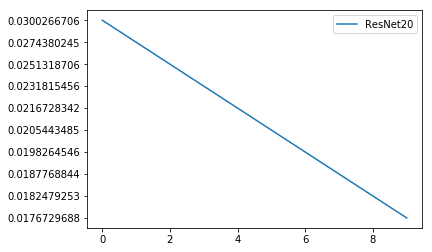

In [48]:
Trainer.plot_loss('ResNet20','ResNet20.png')